In [18]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
%matplotlib inline  

SZ = 32
SIZE = 32
CLASS_N = 9
CLASS_NUMBER = 9
# local modules
from common import clock, mosaic

In [5]:
def load_traffic_dataset():
    dataset = []
    labels = []
    for sign_type in range(CLASS_NUMBER):
        sign_list = listdir("./source/Training/data/{}".format(sign_type))
        for sign_file in sign_list:
            path = "./source/Training/data/{}/{}".format(sign_type,sign_file)
            img = cv2.imread(path,0)
            img = cv2.resize(img, (32,32))
            img = np.reshape(img, [32,32])
            dataset.append(img)
            labels.append(sign_type)
    return np.array(dataset), np.array(labels)

In [26]:
from os import listdir

print(np.array(listdir('./source/Training/data/2'))

[' (1).png' ' (10).png' ' (11).png' ' (12).png' ' (13).png' ' (14).png'
 ' (15).png' ' (16).png' ' (17).png' ' (18).png' ' (19).png' ' (2).png'
 ' (20).png' ' (21).png' ' (22).png' ' (23).png' ' (24).png' ' (25).png'
 ' (26).png' ' (27).png' ' (28).png' ' (29).png' ' (3).png' ' (30).png'
 ' (31).png' ' (32).png' ' (33).png' ' (34).png' ' (35).png' ' (36).png'
 ' (37).png' ' (38).png' ' (39).png' ' (4).png' ' (40).png' ' (41).png'
 ' (42).png' ' (43).png' ' (44).png' ' (45).png' ' (46).png' ' (47).png'
 ' (48).png' ' (49).png' ' (5).png' ' (50).png' ' (51).png' ' (52).png'
 ' (53).png' ' (54).png' ' (55).png' ' (56).png' ' (57).png' ' (58).png'
 ' (59).png' ' (6).png' ' (60).png' ' (61).png' ' (62).png' ' (63).png'
 ' (64).png' ' (65).png' ' (66).png' ' (7).png' ' (8).png' ' (9).png']


In [67]:
hog_descriptors.shape

(586, 81)

In [8]:
def split2d(img, cell_size, flatten=True):
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = [np.hsplit(row, w//sx) for row in np.vsplit(img, h//sy)]
    cells = np.array(cells)
    if flatten:
        cells = cells.reshape(-1, sy, sx)
    return cells

def load_digits(fn):
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    labels = np.repeat(np.arange(CLASS_N), len(digits)/CLASS_N)
    return digits, labels

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img, M, (SZ, SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

class StatModel(object):
    def load(self, fn):
        self.model.load(fn)  # Known bug: https://github.com/opencv/opencv/issues/4969
    def save(self, fn):
        self.model.save(fn)

class SVM(StatModel):
    def __init__(self, C = 12.5, gamma = 0.50625):
        self.model = cv2.ml.SVM_create()
        self.model.setGamma(gamma)
        self.model.setC(C)
        self.model.setKernel(cv2.ml.SVM_RBF)
        self.model.setType(cv2.ml.SVM_C_SVC)

    def train(self, samples, responses):
        self.model.train(samples, cv2.ml.ROW_SAMPLE, responses)

    def predict(self, samples):

        return self.model.predict(samples)[1].ravel()


def evaluate_model(model, digits, samples, labels):
    resp = model.predict(samples)
    print(resp)
    err = (labels != resp).mean()
    print('Accuracy: %.2f %%' % ((1 - err)*100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, resp):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)

    vis = []
    for img, flag in zip(digits, resp == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[...,:2] = 0
        
        vis.append(img)
    return mosaic(16, vis)

def preprocess_simple(digits):
    return np.float32(digits).reshape(-1, SZ*SZ) / 255.0


def get_hog() : 
    winSize = (20,20)
    blockSize = (10,10)
    blockStride = (5,5)
    cellSize = (10,10)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,histogramNormType,L2HysThreshold,gammaCorrection,nlevels, signedGradient)

    return hog
    affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR



if __name__ == '__main__':

    print('Loading digits from digits.png ... ')
    # Load data.
    #digits, labels = load_digits('digits.png')
    digits, labels = load_traffic_dataset()
    print(digits.shape)
    print('Shuffle data ... ')
    # Shuffle data
    rand = np.random.RandomState(10)
    shuffle = rand.permutation(len(digits))
    digits, labels = digits[shuffle], labels[shuffle]
    
    print('Deskew images ... ')
    digits_deskewed = list(map(deskew, digits))
    
    print('Defining HoG parameters ...')
    # HoG feature descriptor
    hog = get_hog();

    print('Calculating HoG descriptor for every image ... ')
    hog_descriptors = []
    for img in digits_deskewed:
        hog_descriptors.append(hog.compute(img))
    hog_descriptors = np.squeeze(hog_descriptors)
    
    print('Spliting data into training (90%) and test set (10%)... ')
    train_n=int(0.9*len(hog_descriptors))
    digits_train, digits_test = np.split(digits_deskewed, [train_n])
    hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])
    labels_train, labels_test = np.split(labels, [train_n])
    
    
    print('Training SVM model ...')
    model = SVM()
    model.train(hog_descriptors_train, labels_train)

    print('Saving SVM model ...')
    model.save('digits_svm.dat')


    print('Evaluating model ... ')
    vis = evaluate_model(model, digits_test, hog_descriptors_test, labels_test)
    cv2.imwrite("digits-classification.jpg",vis)
    cv2.imshow("Vis", vis)
    cv2.waitKey(0)

Loading digits from digits.png ... 
(586, 32, 32)
Shuffle data ... 
Deskew images ... 
Defining HoG parameters ...
Calculating HoG descriptor for every image ... 
Spliting data into training (90%) and test set (10%)... 
Training SVM model ...
Saving SVM model ...
Evaluating model ... 
[ 8.  8.  0.  0.  7.  7.  1.  6.  8.  8.  0.  7.  8.  0.  0.  0.  0.  8.
  6.  8.  0.  8.  3.  8.  3.  0.  4.  4.  6.  0.  7.  0.  8.  2.  8.  0.
  4.  4.  0.  0.  3.  4.  8.  4.  6.  0.  0.  7.  3.  0.  0.  7.  1.  0.
  4.  3.  8.  1.  3.]
Accuracy: 93.22 %
confusion matrix:
[[15  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  6  0  0  0  0  0  0]
 [ 0  0  0  0  7  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0  0]
 [ 1  0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  0 13  0]
 [ 0  0  0  0  0  0  0  0  0  0]]


In [46]:
def getLabel(model, data):
    cv2.LI
    gray = cv2.cvtColor(data, cv2.COLOR_BGR2GRAY)
    img = [cv2.resize(gray,(SIZE,SIZE))]
    print(np.array(img).shape)
    img_deskewed = list(map(deskew, img))
    hog = get_hog()
    hog_descriptors = np.array([hog.compute(img_deskewed[0])])
    hog_descriptors = np.reshape(hog_descriptors, [-1, hog_descriptors.shape[1]])
    return int(model.predict(hog_descriptors)[0])


In [47]:
getLabel(model, a)

(1, 32, 32)


4

In [39]:
a = cv2.imread("./source/Training/data/4/ (1).png")

In [ ]:
b = cv2.imread()

In [13]:
a.shape

(27, 32)

In [32]:
a = [cv2.resize(a, (32,32))]
a_deskewed = list(map(deskew, a))

In [33]:
hog_descriptors.shape

(586, 324)

In [34]:
h = get_hog()
hs = np.array([h.compute(a_deskewed[0])])

In [35]:
hs.shape

(1, 324, 1)

In [42]:
hs = np.reshape(hs,[-1,81])

In [43]:
model.predict(hs)[0]

error: C:\ci\opencv_1512688052760\work\modules\ml\src\svm.cpp:2005: error: (-215) samples.cols == var_count && samples.type() == 5 in function cv::ml::SVMImpl::predict


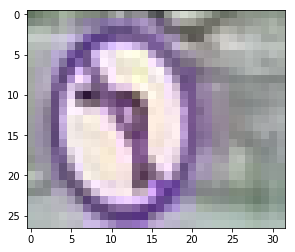

In [3]:
plt.imshow(a)

In [3]:
font = cv2.FONT_HERSHEY_PLAIN
cv2.putText(a,'OpenCV',(10,10), font, 4,(255,255,255),2,cv2.LINE_AA)
cv2.imshow("Test",a)